<a href="https://colab.research.google.com/github/Hrithik2212/CV-for-Self-Driving-Car/blob/main/00_RCNN_Heavy_Vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heavy Vehicle Detection 


In [1]:
!nvidia-smi

Thu Sep 15 15:04:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch-snippets
!pip install selectivesearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 235 kB 11.8 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 1.6 MB 56.2 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=bbe767b3b45f07ffee14587d278aaa7a330c24ab57e08532452126ce2c62e239
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=2ce7038727e870b62e3503b1471eab34dc48464efc7b98795fcf081e34e433b2
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4349 sha256=7274d75af516168c0022415cf32d145ea56ad11245a583f5c3051b6b5079011b
  Stored in directory: /root/.cache/pip/wheels/83/0e/c9/4713ec9c1692e688f84fd3e80201018a02992949ca63697ba8
Successfully built selectivesearch


In [79]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
from torch_snippets import *
import selectivesearch
from google.colab import files
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Wrangling 

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

kaggle.json
 99% 362M/367M [00:02<00:00, 165MB/s]
100% 367M/367M [00:02<00:00, 151MB/s]


## Data Exploration and Preparation 

In [5]:
df = pd.read_csv('/content/df.csv')
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24062 entries, 0 to 24061
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      24062 non-null  object 
 1   Source       24062 non-null  object 
 2   LabelName    24062 non-null  object 
 3   Confidence   24062 non-null  int64  
 4   XMin         24062 non-null  float64
 5   XMax         24062 non-null  float64
 6   YMin         24062 non-null  float64
 7   YMax         24062 non-null  float64
 8   IsOccluded   24062 non-null  int64  
 9   IsTruncated  24062 non-null  int64  
 10  IsGroupOf    24062 non-null  int64  
 11  IsDepiction  24062 non-null  int64  
 12  IsInside     24062 non-null  int64  
 13  XClick1X     24062 non-null  float64
 14  XClick2X     24062 non-null  float64
 15  XClick3X     24062 non-null  float64
 16  XClick4X     24062 non-null  float64
 17  XClick1Y     24062 non-null  float64
 18  XClick2Y     24062 non-null  float64
 19  XCli

In [7]:
df.columns

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y',
       'XClick2Y', 'XClick3Y', 'XClick4Y'],
      dtype='object')

In [8]:
image_data_dir = '/content/images/images'

class Bus_Truck_DataSet(Dataset):
  def __init__(self, df ,img_root = image_data_dir):
    self.root = img_root 
    self.df = df
    self.unique_imgs = df['ImageID'].unique()

  def __len__(self): return len(self.unique_imgs)

  def __getitem__(self , ix ):
    image_id = self.unique_imgs[ix]
    image_path = f'{self.root}/{image_id}.jpg'
    # convert to BGR to RGB 
    img = cv2.imread(image_path,1)[...,::-1]
    h , w , _ = img.shape
    df = self.df.copy()
    df = df[df['ImageID'] == image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
    classes = df['LabelName'].values.tolist()
    return img , boxes , classes , image_path

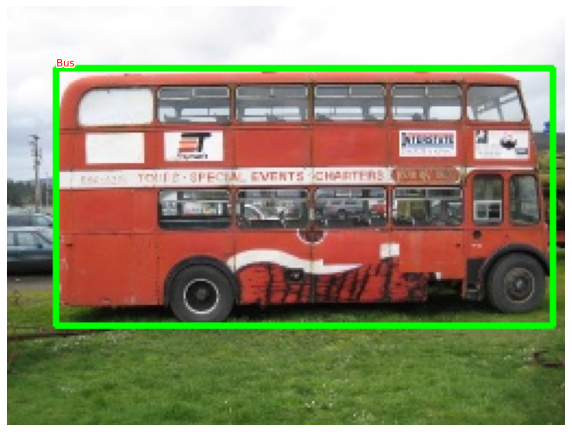

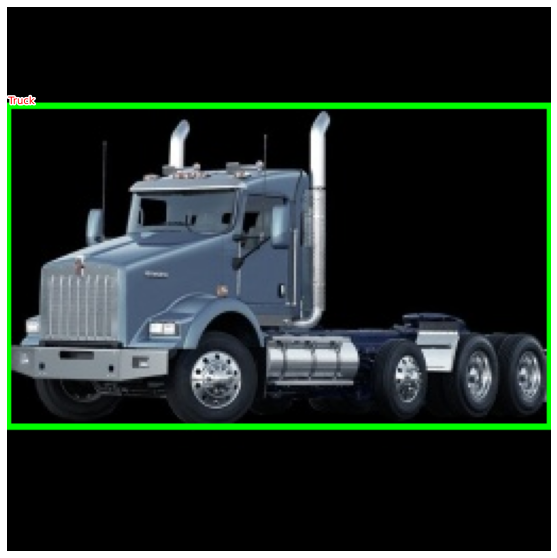

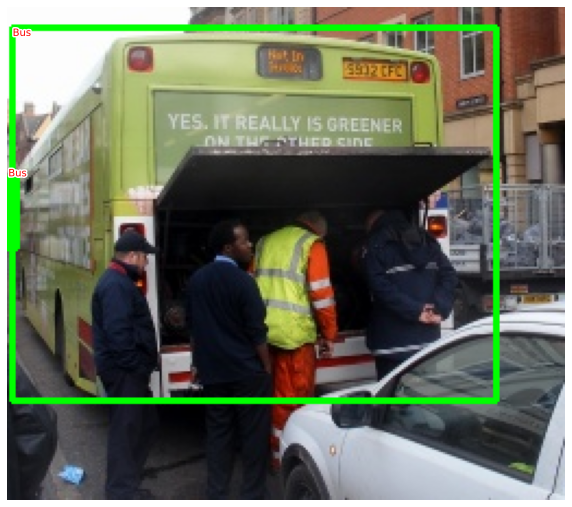

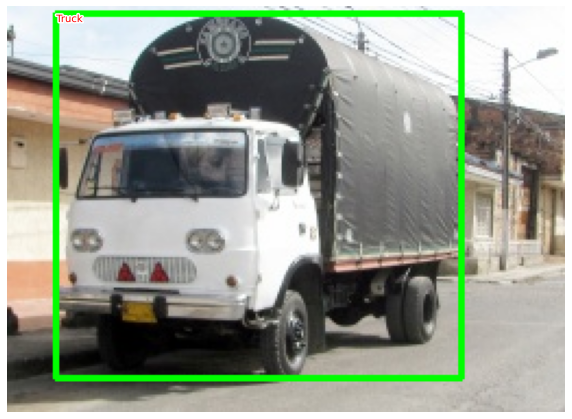

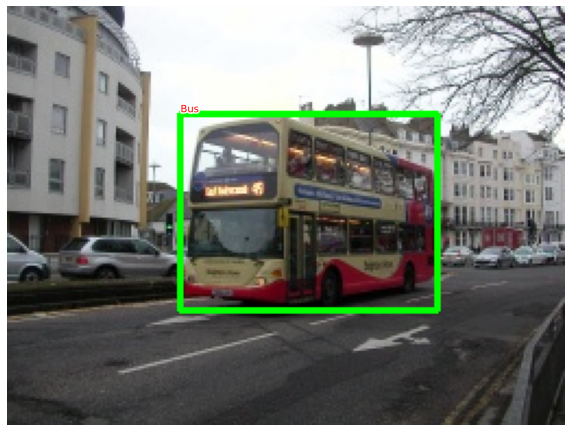

In [9]:
data = Bus_Truck_DataSet(df)
for i in range(100,105):
  im, bbs, clss, _ = data[i]
  show(im, bbs=bbs, texts=clss, sz=10)

In [10]:
def extract_candidates(img):
  img_lbl , regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*img_area): continue
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))
  return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2 - x1)
  height = (y2 - y1)
  if (width<0) or (height <0):
    return 0.0
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined+epsilon)
  return iou

In [11]:
''' 
file paths(FPATHS), 
ground truth bounding
boxes (GTBBS), 
classes (CLSS) of objects, 
the delta offset of a bounding box with region proposals (DELTAS), 
region proposal locations (ROIS), and 
the IoU of region proposals with ground truths (IOUS)
'''

' \nfile paths(FPATHS), \nground truth bounding\nboxes (GTBBS), \nclasses (CLSS) of objects, \nthe delta offset of a bounding box with region proposals (DELTAS), \nregion proposal locations (ROIS), and \nthe IoU of region proposals with ground truths (IOUS)\n'

In [12]:
len(data)

15225

In [13]:
FPATHS , GTBBS , CLSS , DELTAS , ROIS , IOUS = [] , [] , [] , [] , [] , []

In [14]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(data):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{image_data_dir}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [15]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [53]:
normalize = transforms.Normalize(mean= [0.485 , 0.456 ,0.406],
                                std = [0.229 , 0.224 ,0.255])

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  img = normalize(img)
  return img.to(device).float()

def decode(y):
  _ , preds = y.max(-1)
  return preds 

In [54]:
class RCNNDataset(Dataset):
  def __init__(self , fpaths , rois , labels , deltas ,gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs 
    self.rois = rois
    self.labels = labels
    self.deltas = deltas

  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    img_path = str(self.fpaths[ix])
    img = cv2.imread(img_path,1)[...,::-1]
    H , W ,_ = img.shape
    sh = np.array([W,H,W,H])
    gtbbs = self.gtbbs[ix]
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [img[y:Y,x:X] for (x,y,X,Y)  in bbs]
    return img , crops , bbs, labels , deltas , gtbbs , fpath 

  def collate_fn(self,batch):
    input , rois , rixs , labels , deltas = [] , [] , [] , [] , []
    for ix in range(len(batch)):
      image , crops , img_bbs , image_labels , image_deltas , image_gt_bbs , image_fpath = batch[ix]
      crops = [cv2.resize(crop,(224,244)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input , labels , deltas


In [55]:
n_train = 9*len(FPATHS)//10

train_ds = RCNNDataset(FPATHS[:n_train],ROIS[:n_train],CLSS[:n_train],DELTAS[:n_train],GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:],ROIS[n_train:],CLSS[n_train:],DELTAS[n_train:],GTBBS[n_train:])

In [56]:
train_loader = DataLoader(train_ds , batch_size = 2 , collate_fn = train_ds.collate_fn ,drop_last=True)
test_loader = DataLoader(test_ds , batch_size = 2 , collate_fn = train_ds.collate_fn ,drop_last=True)


## Model Building

In [20]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
  param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [81]:
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = vgg_backbone
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
                        nn.Linear(feature_dim , 512),
                        nn.ReLU(),
                        nn.Linear(512,4),
                        nn.Tanh(),
    )
    self.ceil = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()

  def forward(self,input):
    features = self.backbone(input)
    cls_score = self.cls_score(features)
    bbox = self.bbox(features)
    return cls_score , bbox

  def calc_loss(self , probs , _deltas ,labels , deltas ):
    detection_loss = self.ceil(probs ,labels)
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas , deltas )
      return detection_loss + self.lmb * regression_loss , detection_loss.detach() , regression_loss.detach()
    else: 
      regression_loss = 0 
      return detection_loss + self.lmb * regression_loss , detection_loss.detach() , regression_loss.detach()


## Model Training 

In [122]:
def train_batch(inputs , model , optimizer , criterion):
  input , clss , deltas = inputs 
  model.train()
  optimizer.zero_grad()
  _clss , _delats = model(input)
  loss , loc_loss ,reg_loss = criterion(_clss , _delats , clss , deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach().cpu().numpy() , loc_loss.cpu().numpy() , reg_loss.cpu().numpy() , accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs , model , criterion):
  input , clss , deltas = inputs 
  with torch.no_grad():
    model.eval()
    _clss , _deltas = model(input)
    loss , loc_loss , reg_loss = criterion(_clss , _deltas , clss , deltas)
    _ ,_clss = _clss.max(-1)
    accs = clss == _clss
  return _clss, _deltas, loss.detach().cpu().numpy() , loc_loss.cpu().numpy() ,regr_loss, accs.cpu().numpy()


In [138]:
model = RCNN().to(device)
criterion = model.calc_loss
optimizer = optim.SGD(model.parameters() , lr = 1e-3)
EPOCHS = 10

In [139]:
import torchsummary
torchsummary.summary(model , (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [140]:
ta , tcl , trl , ttl = [] , [] , [] , []
va , vcl , vrl , vtl = [] , [] , [] , []
for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  # Train loop 
  for ix , batch in enumerate(train_loader):
    eta , etcl , etrl , ettl = [] , [] , [] , []
    loss , los_loss , regr_loss , accs = train_batch(batch , model , optimizer , criterion )
    eta.append(accs) , etcl.append(los_loss) , etrl.append(regr_loss) , ettl.append(loss)

  print(f'Train -- Total Loss {np.mean(ettl):.5f} | Regression Loss {np.mean(etrl):.5f} | Classification Loss {np.mean(etcl):.5f} | Accuracy {np.mean(eta)*100 :.2f}')
  ta.append(np.mean(eta)) , tcl.append(np.mean(etcl)) , trl.append(np.mean(etrl)) , ttl.append(np.mean(ettl))
  # Validation Loop 
  for ix, batch in enumerate(test_loader):
    eva , evcl , evrl , evtl = [] , [] , [] , []
    _clss , _deltas , loss , loc_loss , reg_loss , accs = validate_batch(batch , model , criterion)
    eva.append(accs) , evcl.append(loc_loss) , evrl.append(reg_loss) , evtl.append(loss)
  
  print(f'Validation -- Total Loss {np.mean(evtl):.5f} | Regression Loss {np.mean(evrl):.5f} | Classification Loss {np.mean(evcl):.5f} | Accuracy {np.mean(eva)*100 :.2f}')
  va.append(np.mean(eva)) , vcl.append(np.mean(evcl)) , vrl.append(np.mean(evrl)) , vtl.append(np.mean(evtl))
  print(f'=====================================================================================Done')

EPOCH 1

Train -- Total Loss 2.17448 | Regression Loss 0.17808 | Classification Loss 0.39372 | Accuracy 81.69

Validation -- Total Loss 1.83581 | Regression Loss 0.17808 | Classification Loss 0.56381 | Accuracy 68.83

=====================================================================================Done

EPOCH 2

Train -- Total Loss 1.65244 | Regression Loss 0.13504 | Classification Loss 0.30205 | Accuracy 85.92

Validation -- Total Loss 1.77942 | Regression Loss 0.13504 | Classification Loss 0.51509 | Accuracy 80.52

=====================================================================================Done

EPOCH 3

Train -- Total Loss 1.36787 | Regression Loss 0.11216 | Classification Loss 0.24622 | Accuracy 88.73

Validation -- Total Loss 1.71653 | Regression Loss 0.11216 | Classification Loss 0.50493 | Accuracy 80.52

=====================================================================================Done

EPOCH 4

Train -- Total Loss 1.10763 | Regression Loss 0.08994 | Classification Loss 0.20825 | Accuracy 91.55

Validation -- Total Loss 1.67640 | Regression Loss 0.08994 | Classification Loss 0.50329 | Accuracy 80.52

=====================================================================================Done

EPOCH 5

Train -- Total Loss 0.91438 | Regression Loss 0.07320 | Classification Loss 0.18234 | Accuracy 91.55

Validation -- Total Loss 1.65142 | Regression Loss 0.07320 | Classification Loss 0.50419 | Accuracy 80.52

=====================================================================================Done

EPOCH 6

Train -- Total Loss 0.84377 | Regression Loss 0.06810 | Classification Loss 0.16281 | Accuracy 97.18

Validation -- Total Loss 1.75440 | Regression Loss 0.06810 | Classification Loss 0.50624 | Accuracy 80.52

=====================================================================================Done

EPOCH 7

Train -- Total Loss 0.69871 | Regression Loss 0.05515 | Classification Loss 0.14720 | Accuracy 98.59

Validation -- Total Loss 1.65684 | Regression Loss 0.05515 | Classification Loss 0.50872 | Accuracy 80.52

=====================================================================================Done

EPOCH 8

Train -- Total Loss 0.64833 | Regression Loss 0.05140 | Classification Loss 0.13430 | Accuracy 98.59

Validation -- Total Loss 1.70649 | Regression Loss 0.05140 | Classification Loss 0.51125 | Accuracy 80.52

=====================================================================================Done

EPOCH 9

Train -- Total Loss 0.54837 | Regression Loss 0.04250 | Classification Loss 0.12341 | Accuracy 98.59

Validation -- Total Loss 1.69907 | Regression Loss 0.04250 | Classification Loss 0.51365 | Accuracy 80.52

=====================================================================================Done

EPOCH 10

Train -- Total Loss 0.57855 | Regression Loss 0.04645 | Classification Loss 0.11409 | Accuracy 98.59

Validation -- Total Loss 1.73387 | Regression Loss 0.04645 | Classification Loss 0.51584 | Accuracy 80.52

=====================================================================================Done

## Evaluation  and Testing 

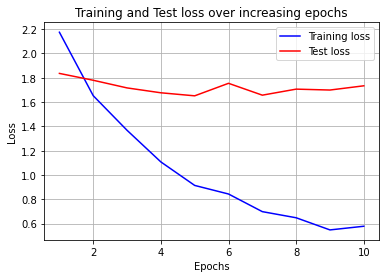

In [141]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, ttl, 'b', label='Training loss')
plt.plot(epochs, vtl , 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


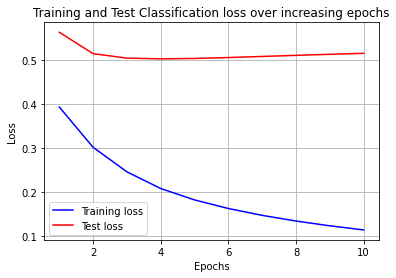

In [142]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, tcl, 'b', label='Training loss')
plt.plot(epochs, vcl , 'r', label='Test loss')
plt.title('Training and Test Classification loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


In [146]:
trl ,vrl 

([0.17807628,
  0.13503967,
  0.112164706,
  0.08993779,
  0.07320334,
  0.06809642,
  0.05515069,
  0.051403183,
  0.042496018,
  0.046445895],
 [0.17807628,
  0.13503967,
  0.112164706,
  0.08993779,
  0.07320334,
  0.06809642,
  0.05515069,
  0.051403183,
  0.042496018,
  0.046445895])

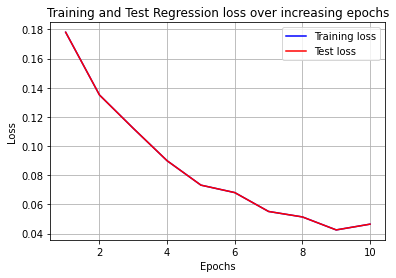

In [147]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, trl, 'b', label='Training loss')
plt.plot(epochs, vrl , 'r', label='Test loss')
plt.title('Training and Test Regression loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


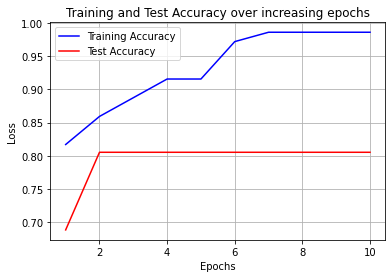

In [148]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va , 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


In [151]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        model.eval()
        probs, deltas = model(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

In [160]:
l = np.random.randint(5,50,10)

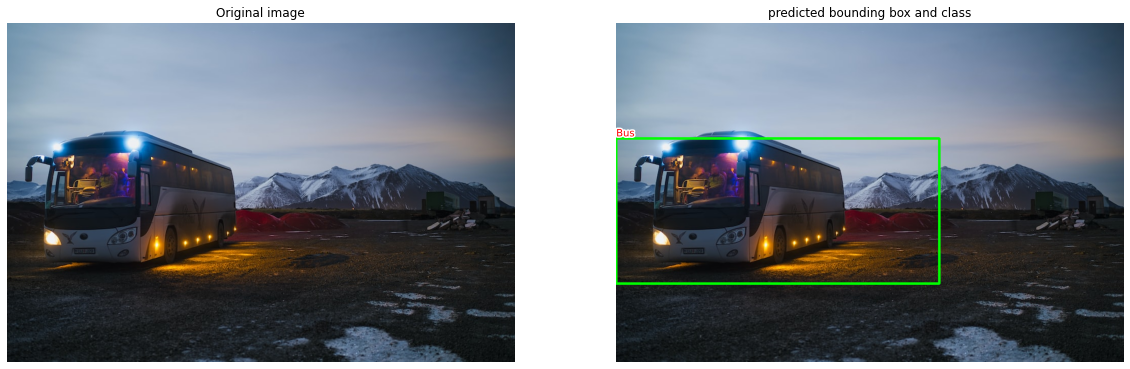

((0, 227, 636, 513), 'Bus', 0.9731401)

In [163]:
test_predictions('/content/bus7.jfif')

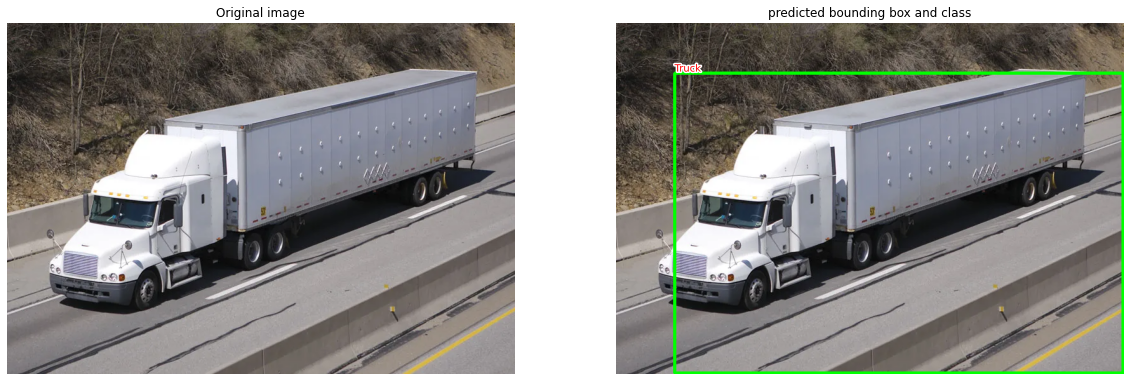

((92, 80, 798, 552), 'Truck', 0.9999943)

In [165]:
test_predictions('/content/trucky.webp')

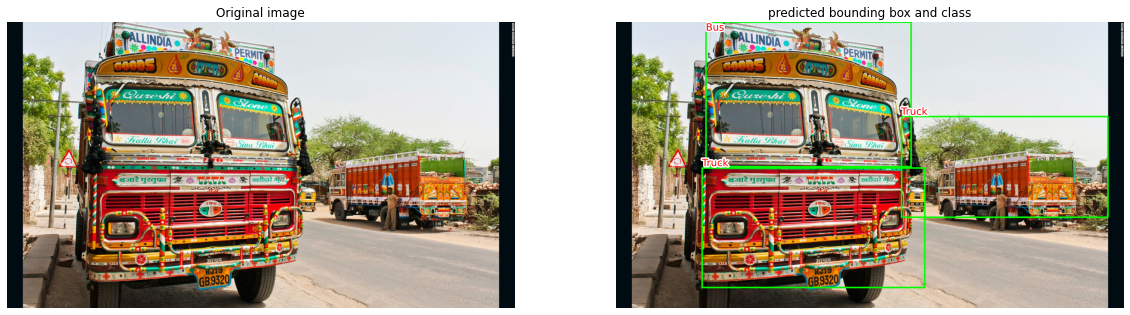

((271, 459, 972, 835), 'Truck', 0.99995875)

In [166]:
test_predictions('/content/t2.jpg') # lol 

## Save the Model 

In [169]:
torch.save(model.to('cpu').state_dict(), 'RCNN-HeavyVechicleDetectorV0.pth')

---